<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=8>Trabajo Final de Master</font></h2>



<h1><font color="#00586D" size=5><i>Reto sobre secuenciación de célula única en linajes celulares de cáncer de mama</i></font></h1>

<br><br><br>
<div align="right">
<font color="#00586D" size=3>Alonso Felipe Ruiz</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>
<br>

---


<a id="Indice"></a>
<h2><font color="#00586D" size=4>Índice</font></h2>

#### <font color="#00586D"> Notebook I</font>
* [1. Introducción](#section1)
* [2. Preparación de los datos](#section2)
* [3. Exploración preliminar](#section3)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np
import glob
import os
import pickle


import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('seaborn')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

---

<a id="section1"></a>
## <font color="#00586D"> 1. Contexto del proyecto</font>
<br>

A lo largo de este trabajo de final de master se utilizará una cohorte de datos obtenida a partir de la sequenciación a nivel de célula única en lineas celulares de cáncer de mama bajo diferentes tratamientos. Estas lineas celulares han sido caracterizadas a nivel genómico, transcriptómico y proteómico. El juego de datos utilizado para este estudio consta de un análisis por citometría de flujo analizando 6 linajes celulares de cáncer de mama, analizando 3015 condiciones distintas, cuantificando 38 marcadores para cada una de ellas.


---

<a id="section2"></a>
## <font color="#00586D"> 2. Predicción de valores perdidos</font>
<br>
El primero de los retos planteados durante el análisis de los datos consiste en la predicción de valores perdidos a partir de los reporteros de las células medidas. La imputación de valores perdidos es esencial en algunos casos, especialmente en el caso de aplicar los conocimientos básicos en clínica. Muchas veces los valores perdidos pueden ser resultado de errores experimentales, pero en otras ocasiones puede deberse a que la implementación de esa medida hace necesario aumentar el coste de la prueba o imposibilita que esta se pueda hacer con equipos convencionales. Este es por ejemplo el caso de la citometría de flujo, donde existen ciertas limitaciones en la técnica que impiden la posibilidad de medir infinitos marcadores al mismo tiempo, además de que aumentar el número de medidas que puedes tomar de manera simultanea, hace requerir de filtros de fluorescencia en el aparato que aumentan enormemente el valor de los mismo.
<br>
En el caso que nos concierne se imputarán los valores perdidos para los siguientes marcadores:
<br>
-phospho-ERK:
<br>
-phospho-Akt(Ser473):
<br>
-phospho-S6:
<br>
-phospho-HER2:
<br>
-phospho-PLCg2:
<br>

Con ese pretexto se plantea el siguiente reto, centrándose específicamente en 6 tipos celulares distintos:
<br>
-AU565:
<br>
-EFM19:
<br>
-HCC2218: 
<br>
-LY2: 
<br>
-MACLS2:
<br>
-MDAMB436:

In [2]:
"""Lectura de los dataframes correspondientes"""
df_goldstandard = pd.read_csv("GoldStandards/sc1gold.csv") #valores reales de los marcadores a predecir
df_AU565p = pd.read_csv("Single_cell_phospho/Challenge1/AU565.csv") #datasets de cada subconjunto de células para hacer el entrenamiento, validación y test
df_EFM19p = pd.read_csv("Single_cell_phospho/Challenge1/EFM19.csv")
df_HCC2218p = pd.read_csv("Single_cell_phospho/Challenge1/HCC2218.csv")
df_LY2p = pd.read_csv("Single_cell_phospho/Challenge1/LY2.csv")
df_MACLS2p = pd.read_csv("Single_cell_phospho/Challenge1/MACLS2.csv")
df_MDAMB436p = pd.read_csv("Single_cell_phospho/Challenge1/MDAMB436.csv")
df_challenge1= (pd.concat([df_AU565p,df_EFM19p,df_HCC2218p,df_LY2p,df_MACLS2p,df_MDAMB436p]))
#Introducimos los valores de los marcadores a predecir en el dataframe
lineas_challenge1=["AU565", "EFM19", "HCC2218", "LY2", "MACLS2", "MDAMB436"]
df_challenge1["p.ERK"]=df_goldstandard["p.ERK"]
df_challenge1["p.Akt.Ser473."]=df_goldstandard["p.Akt.Ser473."]
df_challenge1["p.S6"]=df_goldstandard["p.S6"]
df_challenge1["p.HER2"]=df_goldstandard["p.HER2"]
df_challenge1["p.PLCg2"]=df_goldstandard["p.PLCg2"]

In [3]:
len(df_challenge1.columns)

42

In [4]:
df_challenge1["p.S6"]=df_goldstandard["p.S6"]
df_challenge1.columns

Index(['treatment', 'cell_line', 'time', 'cellID', 'fileID', 'b.CATENIN',
       'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1',
       'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK',
       'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2',
       'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53',
       'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6', 'p.S6K', 'p.SMAD23',
       'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5'],
      dtype='object')

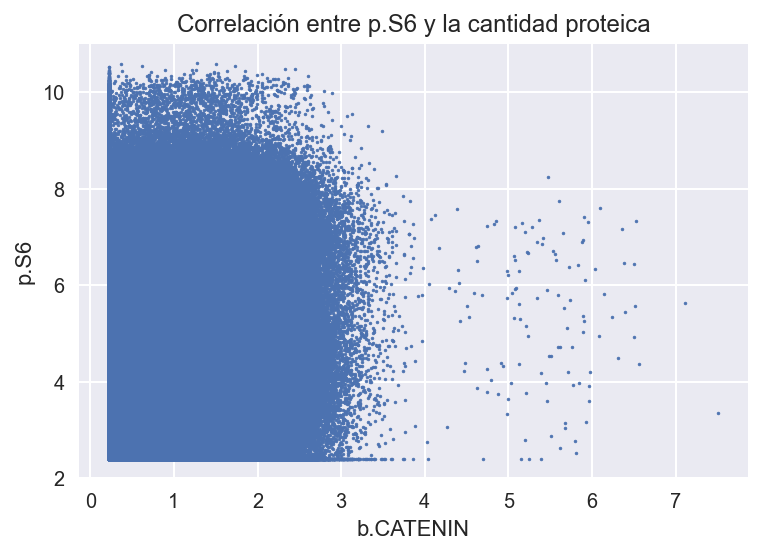

In [5]:
df_challenge1.plot.scatter(x='b.CATENIN', y="p.S6", s=2)
plt.title("Correlación entre p.S6 y la cantidad proteica")
plt.savefig('betacat.png', dpi=1200, bbox_inches='tight', transparent=True)

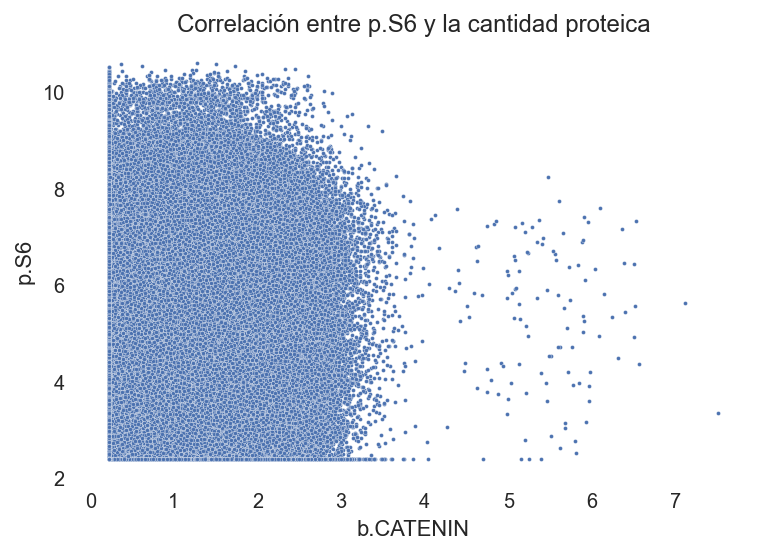

In [10]:
sns.set_style("white")
sns.scatterplot(data=df_challenge1, x='b.CATENIN', y="p.S6", s=4)
plt.title("Correlación entre p.S6 y la cantidad proteica")
plt.savefig('betacat2.png', dpi=1200, bbox_inches='tight')

<a id="section11"></a>
## <font color="#00586D"> 2.2 Analisis exploratorio y preprocesamiento de los datos. </font>
<br>

En este apartado analizaremos los datos de partida, su organización y distribución, así como el procesamiento de los datos iniciales.

In [45]:
#Eliminamos las columnas cellID y fileID que no son informativas
df_challenge1.drop(['cellID', 'fileID'], axis = 1, inplace=True)

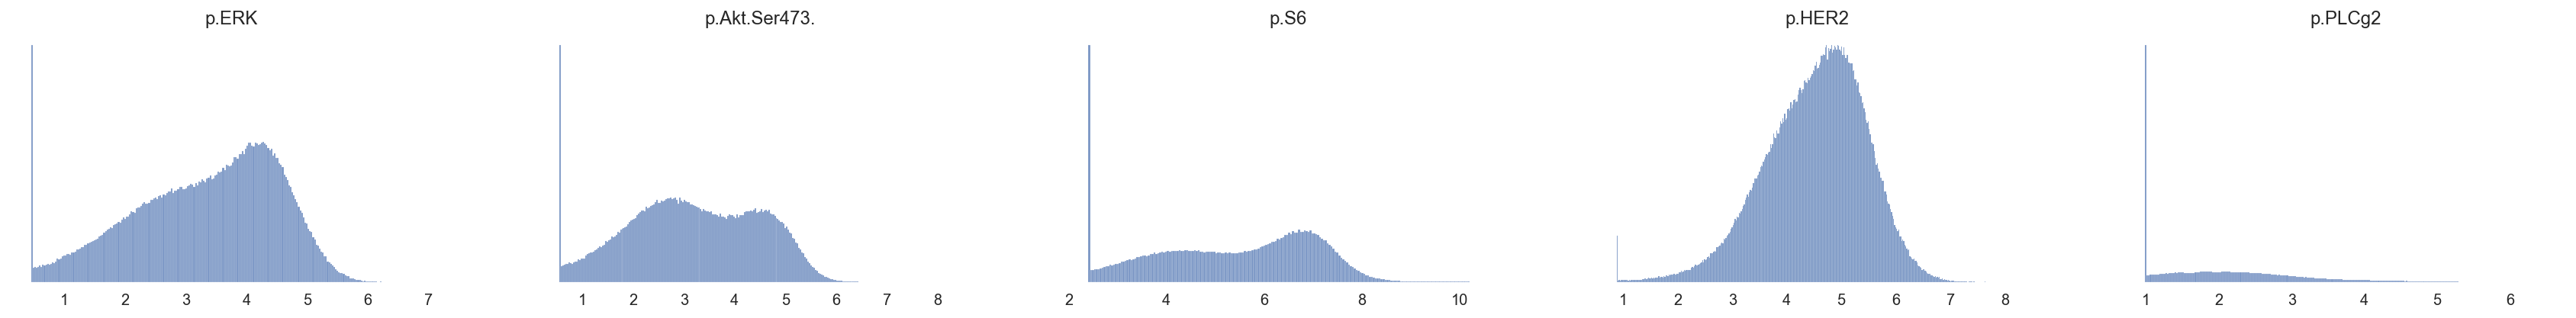

In [13]:
# Análisis de la distribución de las variables a predecir
fig, axes = plt.subplots(1,5, figsize=(30,3))
variables=["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"]
for col, ax in enumerate(axes.flatten()):
    sns.histplot(data=df_challenge1, x=variables[col], ax=ax)
    ax.set_title(variables[col])
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    name=str("plot dist_"+variables[col]+".png")
    plt.savefig(name, dpi=1200, bbox_inches='tight')

In [47]:
df_challenge1.isna().sum()

treatment        0
cell_line        0
time             0
b.CATENIN        0
cleavedCas       0
CyclinB          0
GAPDH            0
IdU              0
Ki.67            0
p.4EBP1          0
p.Akt.Ser473.    0
p.AKT.Thr308.    0
p.AMPK           0
p.BTK            0
p.CREB           0
p.ERK            0
p.FAK            0
p.GSK3b          0
p.H3             0
p.HER2           0
p.JNK            0
p.MAP2K3         0
p.MAPKAPK2       0
p.MEK            0
p.MKK3.MKK6      0
p.MKK4           0
p.NFkB           0
p.p38            0
p.p53            0
p.p90RSK         0
p.PDPK1          0
p.PLCg2          0
p.RB             0
p.S6             0
p.S6K            0
p.SMAD23         0
p.SRC            0
p.STAT1          0
p.STAT3          0
p.STAT5          0
dtype: int64

Vemos aquí uno de los primeros problemas que tendremos que intentar sobrepasar durante el desarrollo del modelo, los valores a predecir de las variables no muestran una distribución normal, además vemos que algunos valores parecen estar sobre representados, también parece haber valores extremos que pueden condicionar la capacidad de predicción del modelo. En el caso de p.HER2 parece que la distribución si es normal y que no hay estos valores sobrerepresentados ni extremos. El dataset parece no mostrar valores perdidos, lo cual es interesante ya que no tendremos que utilizar estrategias de imputación.

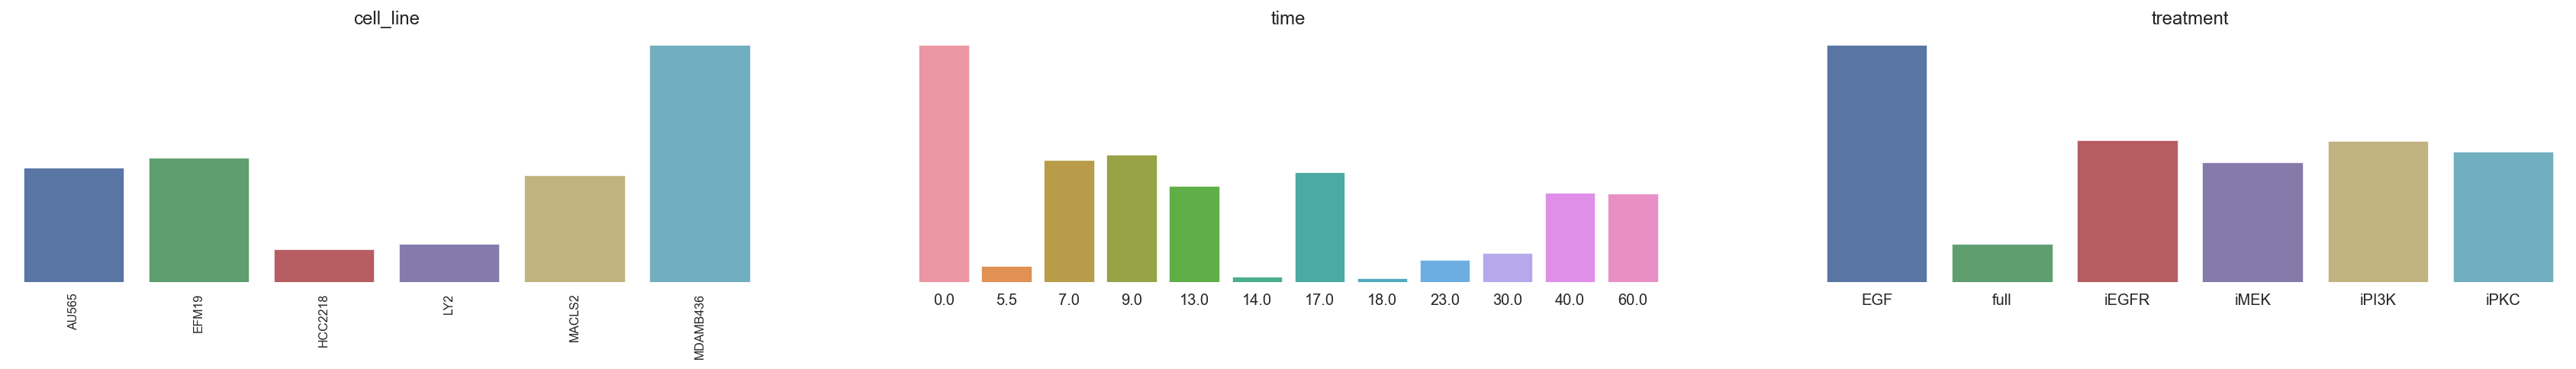

In [15]:
#Análisis de las variables discretas del dataframe que hay que predecir
fig, axes = plt.subplots(1,3, figsize=(30,3))
variables=['cell_line', 'time', 'treatment']
for col, ax in enumerate(axes.flatten()):
    sns.countplot(data=df_challenge1, x=variables[col], ax=ax)
    if col==0:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_title(variables[col])
    ax.set_yticks([])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
plt.savefig("barplot.png", dpi=1200, bbox_inches='tight')

Podemos observar que las lineas celulares tienen diferente represetación, al igual que los tiempos a los que se han obtenido las mediciones. Los tratamientos son 5 diferentes y uno combinatorio de todos ellos. Vamos a categorizar la variable tiempo como una variable discreta ordenal.

In [17]:
#Analizamos la correlación entre las variables numéricas
df_corr=df_challenge1[df_challenge1.select_dtypes(include=np.number).columns].corr()
df_corr.drop(["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"], axis = 0, inplace=True)
df_corr["average"]=(df_corr["p.ERK"]+df_corr["p.Akt.Ser473."]+df_corr["p.S6"]+df_corr["p.HER2"]+df_corr["p.PLCg2"])/5

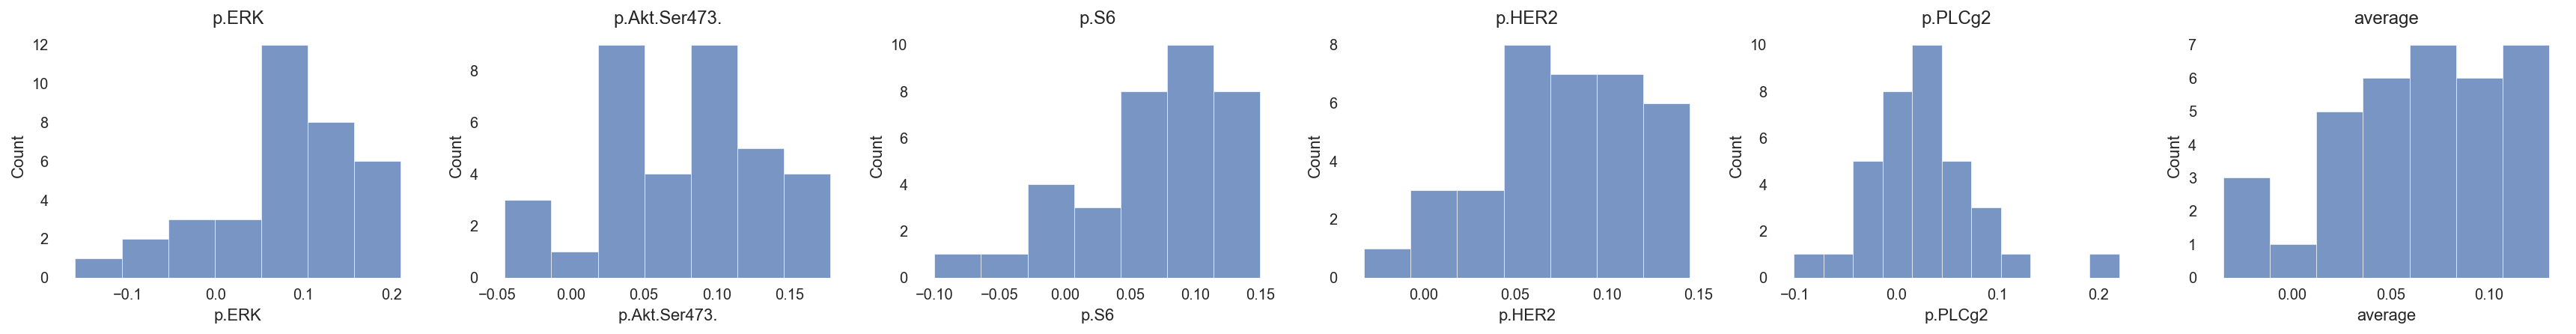

In [18]:
# Análisis de la correlación de las variables a predecir con el resto
fig, axes = plt.subplots(1,6, figsize=(30,3))
variables=["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2", "average"]
for col, ax in enumerate(axes.flatten()):
    sns.histplot(data=df_corr, x=variables[col], ax=ax)
    ax.set_title(variables[col])
plt.savefig("histplot.png", dpi=1200, bbox_inches='tight')

Podemos ver que la correlación entre las variables que utilizaremos en predicción y las que debemos predecir no es excesivamente elevada, rondando valores entre el -0.1 y 0.15. Aunque vemos que al hacer la media de la correlación de las diferentes variables con todas las variables de predicción, algunas de ellas tienen un valor por encima de 0.1. Almacenaremos estas variables en el objeto corr_variables, para si en un futuro es una variable de interés.

In [51]:
corr_variables=df_corr.query("average >= 0.1 ")["average"].index.to_list()
corr_variables

['p.GSK3b',
 'p.JNK',
 'p.MAPKAPK2',
 'p.MEK',
 'p.MKK4',
 'p.p38',
 'p.p90RSK',
 'p.S6K',
 'p.STAT5']

In [52]:
#Preparamos los juegos de datos de entrenamiento y test
from sklearn.model_selection import train_test_split
y=df_challenge1[["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"]]
df_challenge1.drop(["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_challenge1, y, test_size=0.33, random_state=1)

print(f' dataset entrenamiento tiene {X_train.shape}')
print(f' dataset test tiene {X_test.shape}')


 dataset entrenamiento tiene (1596648, 35)
 dataset test tiene (786410, 35)


In [53]:
#Separamos las variables numéricas y categóricas
dis_df_columns = X_train.select_dtypes(exclude=np.number).columns
num_df_columns = X_train.select_dtypes(include=np.number).columns
#Separamos time que lo utilizaremos como una variable discreta ordinal y las usadas en predicción
num_df_columns = num_df_columns.drop(["time"])

In [12]:
dis_df_columns

Index(['treatment', 'cell_line'], dtype='object')

In [13]:
num_df_columns

Index(['b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67',
       'p.4EBP1', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.FAK',
       'p.GSK3b', 'p.H3', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2', 'p.MEK',
       'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53', 'p.p90RSK',
       'p.PDPK1', 'p.RB', 'p.S6K', 'p.SMAD23', 'p.SRC', 'p.STAT1', 'p.STAT3',
       'p.STAT5'],
      dtype='object')

En este momento podemos comenzar ya con el procesamiento de los datos, para ello vamos a hacer un pipeline de sckitlearn en el que implementemos la transformación de las columnas.

In [63]:
#Pipeline de preprocesamiento
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Lista de tiempos que se usaran en el ensayo
time_cat = [[0.0, 5.5, 7.0, 9.0, 13.0, 14.0, 17.0, 18.0, 23.0, 30.0, 40.0, 60.0]]
time_transformer = Pipeline([('Ordinal_encoder', OrdinalEncoder())])
treatment_transformer = Pipeline([('onehot', OneHotEncoder())])
num_transformer = Pipeline([('scaler', StandardScaler())])
phospho_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_df_columns),
        ('treat', treatment_transformer, ["treatment"]),
        ('time', time_transformer, ['time'])])

In [18]:
#Si quisieramos entrenar y procesar los datos a priori. Entrenamos el pipeline de preprocesado
#phospho_trans.fit(X_train)
#X_train=phospho_trans.transform(X_train)
#X_test=phospho_trans.transform(X_test)

In [19]:
#Guardamos el transofrmador
#from pickle import dump
#dump(phospho_trans, open('Models/scaler.pkl', 'wb'))

<a id="section12"></a>
## <font color="#00586D"> 2.3 Modelo predictivo de los niveles de marcadores fosforilados. </font>
<br>

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# DataFrame con los resultados
# Si no se han generado ningún resultado lo genera.
if not os.path.isfile("results.csv"):
    results = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Validación','$R^2$ Test', 
                                         'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
# Si se habían generado anteriormente, y el archivo está disponible, lo lee. 
else:
    results=pd.read_csv("results.csv", index_col=0)

def show_results(description, model, X_train, y_train, X_test, y_test, is_log=False):
    train_r2 = model.score(X_train,y_train)
    print('Score done')
    val_r2 = cross_val_score(model,X_train,y_train,cv=3).mean()
    print('cross val score done')
    test_r2 = model.score(X_test, y_test)
    print('Score 2 done')
    # Calcula el error    
    train_mae = mean_absolute_error(y_train, model.predict(X_train))
    test_mae = mean_absolute_error(y_test, model.predict(X_test))
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    results.loc[description]= (train_r2, val_r2, test_r2, train_mae, test_mae)

El número de parámetros que serán testados durante los GridSearchCV, al igual que el número de CV se han mantenido bastante reducidos para evitar así un tiempo excesivo de procesamiento.

In [ ]:
#Comenzaremos con un modelo sencillo de regresión lineal de Ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

parameters = {'clas__alpha':np.logspace(-4, 4, 9, endpoint=True)}
phospho_pipe_ridge = Pipeline([('prep', phospho_trans),
                 ('clas', Ridge())])
GS = GridSearchCV(phospho_pipe_ridge, param_grid=parameters, cv=5, verbose=10)
GS.fit(X_train, y_train)
        
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

ridge = GS.best_estimator_

description = 'Ridge regression para la predicción de marcadores de fosforilación'
show_results(description, ridge, X_train, y_train, X_test, y_test)

In [ ]:
#Guardar el modelo y los resultados
filename = 'Models/Ridge_T.sav'
pickle.dump(ridge, open(filename, 'wb'))
results.to_csv("results.csv")

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'clas__max_depth':np.linspace(1,15,5), 'clas__min_samples_split':(2,4,6,8,10)}
phospho_pipe_DT = Pipeline([('prep', phospho_trans),
                 ('clas', DecisionTreeRegressor())])
GS = GridSearchCV(phospho_pipe_DT, param_grid=parameters, cv=5, verbose=10)
GS.fit(X_train, y_train)
        
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

tree = GS.best_estimator_
description = 'Regression tree para la predicción de marcadores de fosforilación'
show_results(description, tree, X_train, y_train, X_test, y_test)

In [ ]:
#Guardar el modelo y los resultados
filename = 'Models/DecTree_T.sav'
pickle.dump(tree, open(filename, 'wb'))
results.to_csv("results.csv")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'clas__max_depth':[1,5,10,15,20]}
phospho_pipe_RF = Pipeline([('prep', phospho_trans),
                 ('clas', RandomForestRegressor())])
GS = GridSearchCV(phospho_pipe_RF, param_grid=parameters, cv=5, verbose=10)
GS.fit(X_train, y_train)
        
print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

RF = GS.best_estimator_
description = 'Random forest para la predicción de marcadores de fosforilación'
show_results(description, RF, X_train, y_train, X_test, y_test)

In [ ]:
#Guardar el modelo y los resultados
filename = 'Models/RF_T.sav'
pickle.dump(RF, open(filename, 'wb'))
results.to_csv("results.csv")

Aprovechando que hemos realizado un modelo Random Forest que obtiene la importancia de las características basándose en la impureza de los árboles. Vamos a obtener las 10 características más relevantes y las vamos a comparar con las que obtuvimos con los análisis de correlación. Lo almacenaremos en la variable RF_variables. Nos dará como resultado el número de las columnas tras el preprocesamiento de los datos, así que tendremos que analizar el pipeline de preprocesamiento para observar cuales son las columnas con mayor importancia.

In [27]:
RF_variables = np.argsort(RF._final_estimator.feature_importances_)[:-10:-1]
print(f'variables importantes RF {RF_variables}')

variables importantes RF [38 26 32  3 23 20 25 22 12]


Estas variables al analizar el pipeline de preprocesamiento nos damos cuenta de que son las siguientes:
-Tiempo parece ser la de mayor importancia.
-Seguido de p.S6K.
-Seguido por una de las columnas del OneHot encoder del tratamiento.
-GAPDH.
-p.p90RSK.
-p.NFkB.
-p.RB.
-p.p53.
-p.GSK3b.

Generaremos una variable llamada rel_feat con las variables que parecen más importantes.

In [9]:
rel_feat=["time", "p.S6K", "treatment", "GAPDH", "p.p90RSK", "p.NFkB", "p.RB", "p.p53", "p.GSK3b"]

num_rel_columns= ["p.S6K", "GAPDH", "p.p90RSK", "p.NFkB", "p.RB", "p.p53", "p.GSK3b"]

print(f'variables importantes RF {rel_feat} \n variables importantes correlación {corr_variables}')

variables importantes RF ['time', 'p.S6K', 'treatment', 'GAPDH', 'p.p90RSK', 'p.NFkB', 'p.RB', 'p.p53', 'p.GSK3b'] 
 variables importantes correlación ['p.GSK3b', 'p.JNK', 'p.MAPKAPK2', 'p.MEK', 'p.MKK4', 'p.p38', 'p.p90RSK', 'p.S6K', 'p.STAT5']


In [10]:
for it in rel_feat:
    if it in corr_variables:
        print(it)

p.S6K
p.p90RSK
p.GSK3b


Podemos observar que algunas de estas variables determinadas como importantes a la hora de generar el modelo de RF son las que anteriormente habíamos determinado con una mayor correlación con las variables de salida. Esto es el caso de p.S6K, p.p90RSK y p.GSK3b. Aunque muchas otras no son compartidas entre ambas listas. Para los siguientes modelos, vamos a generar un nuevo pipeline de preprocesamiento en el que nos centremos solamente en estas variables que parecen almacenar una mayor información sobre la distribución de las variables y procederemos a realizar modelos de tipo KNN para ver si obtenemos unos mejores resultados.

In [18]:
#Pipeline de transformación para las variables importantes en RF
time_cat = [[0.0, 5.5, 7.0, 9.0, 13.0, 14.0, 17.0, 18.0, 23.0, 30.0, 40.0, 60.0]]
time_transformer = Pipeline([('Ordinal_encoder', OrdinalEncoder())])
treatment_transformer = Pipeline([('onehot', OneHotEncoder())])
num_transformer = Pipeline([('scaler', StandardScaler())])
phospho_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_rel_columns),
        ('treat', treatment_transformer, ["treatment"]),
        ('time', time_transformer, ['time'])])

In [ ]:
#Modelo de tipo KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
parameters = {'clas__n_neighbors':(1,5,10,15,20), 'clas__weights':('uniform','distance')}
phospho_pipe_knn= Pipeline([('prep', phospho_trans),
                 ('clas', KNeighborsRegressor())])
GS = GridSearchCV(phospho_pipe_knn, param_grid=parameters, cv=3, verbose=10)
GS.fit(X_train[rel_feat], y_train)

print("Mejor score: ", GS.best_score_)
print("Mejor configuración de parámetros: ", GS.best_params_)

knn = GS.best_estimator_
description = 'k-NN (STD) para la predicción de marcadores de fosforilación'
show_results(description, knn, X_train[rel_feat], y_train, X_test[rel_feat], y_test)

In [ ]:
#Guardar el modelo y los resultados
filename = 'Models/KNN_T.sav'
pickle.dump(knn, open(filename, 'wb'))
results.to_csv("results.csv")

In [26]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression para la predicción de marcadores de fosforilación,0.107172,0.107121,0.106924,0.911959,0.911695
Regression tree para la predicción de marcadores de fosforilación,0.262342,0.199459,0.204143,0.800711,0.833326
Random forest para la predicción de marcadores de fosforilación,0.484126,0.267036,0.269355,0.659202,0.796952
k-NN (STD) para la predicción de marcadores de fosforilación,0.280478,0.203063,0.203025,0.791528,0.832757


Podemos observar que el modelo con un mejor desempeño ha sido el modelo de RandomForest, aunque este ha sido igualmente muy reducido. 

Dado el reducido desempeño de los modelos a la hora de hacer predicción, vamos a probar a hacerlo ahora de manera más sencilla, intentando generar un modelo de RF (el que parece tener mayor capacidad para predecir en este problema, pero en lugar de intentar modelizar todas las variables de interés a la vez, vamos a intentar hacerlo solo con una, empezando por la variable p.ERK.

In [16]:
y_train.columns.to_list()

['p.ERK', 'p.Akt.Ser473.', 'p.S6', 'p.HER2', 'p.PLCg2']

In [ ]:
#RF para los diferentes modelos únicos
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
marcadores=y_train.columns.to_list()
parameters = {'clas__max_depth':[20]}
phospho_pipe_RF = Pipeline([('prep', phospho_trans),
                 ('clas', RandomForestRegressor())])
for prot in marcadores:
    GS = GridSearchCV(phospho_pipe_RF, param_grid=parameters, cv=2, verbose=10)
    GS.fit(X_train, y_train[prot])

    print("Mejor score: ", GS.best_score_)
    print("Mejor configuración de parámetros: ", GS.best_params_)

    RF = GS.best_estimator_
    description = 'Random forest para la predicción de marcadores de fosforilación para S6'
    show_results(description, RF, X_train, y_train[prot], X_test, y_test[prot])
    #Guardar el modelo y los resultados
    filename = 'Models/RF_T_' + prot + '.sav'
    pickle.dump(RF, open(filename, 'wb'))
    results.to_csv("results.csv")

In [50]:
#Guardar el modelo y los resultados
filename = 'Models/RF_T_S6.sav'
pickle.dump(RF, open(filename, 'wb'))
results.to_csv("results.csv")

In [17]:
results.tail(5)

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Random forest para la predicción de marcadores de fosforilación para ERK,0.648831,0.445739,0.448701,0.535986,0.676394
Random forest para la predicción de marcadores de fosforilación para AktSer473,0.552290,0.314845,0.317640,0.668882,0.839643
Random forest para la predicción de marcadores de fosforilación para S6,0.492526,0.233117,0.235130,0.908762,1.131703
Random forest para la predicción de marcadores de fosforilación para HER2,0.420765,0.204941,0.206449,0.536901,0.634239
Random forest para la predicción de marcadores de fosforilación para PLCg2,0.441369,0.140865,0.143914,0.567205,0.699614


In [40]:
#Comparamos ahora con el desempeño del modelo inicial
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
results_RF = pd.DataFrame(columns=['Modelo','$R^2$ Entrenamiento','$R^2$ Test', 
                                     'MAE Entrenamiento', 'MAE Test']).set_index('Modelo')
RF = pickle.load(open("Models/RF_T.sav", 'rb'))
prots={"p.ERK":0, "p.Akt.Ser473.":1, "p.S6":2, "p.HER2":3, "p.PLCg2":4}
pred_train=RF.predict(X_train)
pred_test=RF.predict(X_test)
for prot, pos in prots.items():
    mae_train=MAE(pd.DataFrame(pred_train)[pos], y_train[prot])
    train=r2(pd.DataFrame(pred_train)[pos], y_train[prot])
    test=r2(pd.DataFrame(pred_test)[pos], y_test[prot])
    mae_test=MAE(pd.DataFrame(pred_test)[pos], y_test[prot])
    description="RF completo " + prot 
    results_RF.loc[description]= (train, test, mae_train, mae_test)
results_RF

,$R^2$ Entrenamiento,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,
RF completo p.ERK,0.071705,-0.454825,0.570161,0.681778
RF completo p.Akt.Ser473.,-0.428762,-1.403205,0.692760,0.840959
RF completo p.S6,-0.867139,-2.570201,0.906776,1.128515
RF completo p.HER2,-1.359869,-3.168373,0.529961,0.634144
RF completo p.PLCg2,-2.925734,-6.145942,0.596354,0.699366


Podemos ver que el desempeño a nivel individual para cada uno de los modelos era incluso mucho peor que el que obteníamos en general, de ahí que sea conveniente entrenar todos los modelos de manera individual. Por ello, ahora aprovecharemos los modelos individuales para hacer un análisis de explicabilidad para ver si podemos obtener algo de información biológica a partir de los modelos.

In [54]:
import shap
shap.initjs()

Seleccionaremos las muestras con los valores mayores y menores para cada una de las variables de interés para hacer los análisis de la predicción.

In [55]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_T_ERK.sav", 'rb'))
y_pred = RF.predict(X_test)
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de ERK
max_idx=pd.DataFrame(y_pred).idxmax().to_list()
min_idx=pd.DataFrame(y_pred).idxmin().to_list()
samples=X_test.iloc[max_idx+min_idx]

In [56]:
samples

,treatment,cell_line,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,...,p.p53,p.p90RSK,p.PDPK1,p.RB,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
376447,iPKC,AU565,9.0,1.102754,4.261820,2.97376,2.702472,6.03158,4.67898,5.081445,...,4.346567,7.19595,2.333273,8.25774,4.853142,3.548781,3.212751,4.076934,3.736752,4.571968
144391,iEGFR,AU565,0.0,0.224784,1.563354,1.60727,0.565534,13.26448,1.77969,1.544045,...,5.692595,2.16643,0.718530,4.71924,0.501635,0.551474,0.554053,0.132590,0.652426,1.070064


Una cosa que era de esperar es que la muestra con menor valor predicho es a tiempo 0, cosa que podría ser comprensible si los tratamientos llevan a un cierto aumento de los niveles de fosforilación de ERK.

In [57]:
explainer = shap.TreeExplainer(RF._final_estimator)
sampleID=samples.index

In [64]:
#Tenemos que preprocesar los datos
phospho_trans.fit(X_train)
samples=phospho_trans.transform(samples)
columns=num_df_columns.to_list() + ["EGF", "full", "iEGFR", "iMEK", "iPI3K", "iPKC", "time"]

In [65]:
#Muestra con el valor máximo
sample=0
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 0, que corresponde a la muestra con un valor predicho mayor para ERK, vemos que la variable con mayor importancia es los niveles de p.S6K fosforilado, aunque también es importante los niveles de p90RSK fosforilados.

In [66]:
sample=1
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 1, que corresponde a la muestra con un menor valor predicho para ERK, vemos que aparece el marcador de daño en el DNA, desoxi yodo uridina, esto tiene todo el sentido ya que un marcador de daño en el DNA implicará que las células están en peor estado y seguramente todas sus rutas de señalización están alteradas. También es interesante que algunos tratamiento parecen influenciar en una predicción de valores más reducidos de ERK, por ejemplo la ausencia de tratamiento con EGF o el uso de tratamiento con iEGFR parece que llevan a menores valores de ERK fosforilado.

In [67]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_T_Akt.sav", 'rb'))
y_pred = RF.predict(X_test)
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de ERK
max_idx=pd.DataFrame(y_pred).idxmax().to_list()
min_idx=pd.DataFrame(y_pred).idxmin().to_list()
samples=X_test.iloc[max_idx+min_idx]

In [68]:
samples

,treatment,cell_line,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,...,p.p53,p.p90RSK,p.PDPK1,p.RB,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
115203,EGF,AU565,60.0,1.067735,0.898342,1.20489,3.033719,5.47479,3.46107,2.168473,...,3.675485,6.99383,2.425515,5.08999,4.964857,3.467443,3.888979,4.591507,2.288745,5.206345
166538,iEGFR,AU565,9.0,0.445714,2.160952,1.20489,0.565534,13.23353,2.11571,0.993163,...,4.470013,1.31100,0.516309,5.90745,0.331558,0.908107,0.812984,-0.145290,0.868569,0.689873


Una cosa que era de esperar es que la muestra con mayor valor predicho es a tiempo 60, esto parece indicar que en esas condiciones el marcador se va acumulando co el tiempo.

In [69]:
explainer = shap.TreeExplainer(RF._final_estimator)
sampleID=samples.index

In [70]:
#Tenemos que preprocesar los datos
phospho_trans.fit(X_train)
samples=phospho_trans.transform(samples)
columns=num_df_columns.to_list() + ["EGF", "full", "iEGFR", "iMEK", "iPI3K", "iPKC", "time"]

In [71]:
#Muestra con el valor máximo
sample=0
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 0, que corresponde a la muestra con un valor predicho mayor para Akt, vuelve a tener importancia los niveles de p.S6K fosforilado, aunque también es importante los niveles de STAT5 y parece ser que la ausencia de tratamiento con iEGFR lleva a predicciones de valores más elevados de fosfo Akt, probablemente significando que este tratamiento altera esta ruta de señalización.

In [72]:
sample=1
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 1, que corresponde a la muestra con un menor valor predicho para Akt, vemos que contrastando lo visto en la muestra anterior, ahora lo que más peso tiene es el tratamiento con iEGFR constatando que este tratamiento afecta a los niveles de Akt fosforilado, también aparece el marcador de daño en el DNA, desoxi yodo uridina, con la misma explicación que el caso anterior.

In [73]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_T_HER2.sav", 'rb'))
y_pred = RF.predict(X_test)
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de ERK
max_idx=pd.DataFrame(y_pred).idxmax().to_list()
min_idx=pd.DataFrame(y_pred).idxmin().to_list()
samples=X_test.iloc[max_idx+min_idx]

In [74]:
samples

,treatment,cell_line,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,...,p.p53,p.p90RSK,p.PDPK1,p.RB,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
363806,iPKC,AU565,7.0,0.224784,3.222450,1.20489,3.142744,6.23652,3.90044,3.518341,...,7.054415,6.83277,0.516309,4.61511,4.462662,3.715610,3.673562,3.740006,7.087613,4.929775
68527,EGF,AU565,13.0,0.224784,0.898342,1.20489,0.565534,8.63720,1.59085,0.993163,...,0.798554,1.05682,0.516309,2.20794,0.331558,0.551474,0.683272,-0.341181,0.652426,-0.577393


In [75]:
explainer = shap.TreeExplainer(RF._final_estimator)
sampleID=samples.index

In [76]:
#Tenemos que preprocesar los datos
phospho_trans.fit(X_train)
samples=phospho_trans.transform(samples)
columns=num_df_columns.to_list() + ["EGF", "full", "iEGFR", "iMEK", "iPI3K", "iPKC", "time"]

In [77]:
#Muestra con el valor máximo
sample=0
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 0, que corresponde a la muestra con un valor predicho mayor para HER2, vemos que nuevamente aparece p.S6K fosforilado, aunque también es importante los niveles de p90RSK fosforilados, caso idéntico al de ERK.

In [78]:
sample=1
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 1, que corresponde a la muestra con un menor valor predicho para HER2, podemos apreciar que valores muy reducidos de p.AMPK y p.STAT1 están correlacionados con menores niveles de fosfo HER2.

In [79]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_T_S6.sav", 'rb'))
y_pred = RF.predict(X_test)
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de ERK
max_idx=pd.DataFrame(y_pred).idxmax().to_list()
min_idx=pd.DataFrame(y_pred).idxmin().to_list()
samples=X_test.iloc[max_idx+min_idx]

In [80]:
samples

,treatment,cell_line,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,...,p.p53,p.p90RSK,p.PDPK1,p.RB,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
317280,iPI3K,AU565,13.0,0.334116,1.409685,6.91357,2.393116,6.50379,7.27796,0.993163,...,5.003880,7.47193,1.990846,9.00315,4.658723,2.710035,3.352110,4.773954,0.652426,4.57271
186165,iEGFR,AU565,13.0,0.918887,1.801950,2.66792,1.085382,12.92516,2.47213,1.511453,...,5.896343,1.80881,0.516309,4.82452,1.372400,1.444189,0.554053,1.419763,1.309619,1.11934


Una cosa que era de esperar es que la muestra con menor valor predicho es a tiempo 0, cosa que podría ser comprensible si los tratamientos llevan a un cierto aumento de los niveles de fosforilación de ERK.

In [81]:
explainer = shap.TreeExplainer(RF._final_estimator)
sampleID=samples.index

In [82]:
#Tenemos que preprocesar los datos
phospho_trans.fit(X_train)
samples=phospho_trans.transform(samples)
columns=num_df_columns.to_list() + ["EGF", "full", "iEGFR", "iMEK", "iPI3K", "iPKC", "time"]

In [83]:
#Muestra con el valor máximo
sample=0
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 0, que corresponde a la muestra con un valor predicho mayor para S6, el resultado es idéntico al de ERK y HER2, teniendo gran importancia p.S6K y los niveles de p90RSK fosforilados.

In [84]:
sample=1
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 1, que corresponde a la muestra con un menor valor predicho para S6, se puede observar que los niveles de GSK3b reducidos pueden tener cierto impacto en una predicción de S6 reducida, vemos también que el marcador p53 elevado suele ser también un habitual en las muestras con predicción de valores reducidos, este es un marcador de proliferación celular y puede tener cierta correlación con que los tratamientos no estén siendo eficaces.

In [85]:
#Modelo para la predicción de ERK
RF = pickle.load(open("Models/RF_T_PLCg2.sav", 'rb'))
y_pred = RF.predict(X_test)
#Nos quedaremos con las filas para las que ha predicho un valor mayor y menor de ERK
max_idx=pd.DataFrame(y_pred).idxmax().to_list()
min_idx=pd.DataFrame(y_pred).idxmin().to_list()
samples=X_test.iloc[max_idx+min_idx]

In [86]:
samples

,treatment,cell_line,time,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,p.4EBP1,...,p.p53,p.p90RSK,p.PDPK1,p.RB,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
298137,iPI3K,AU565,7.0,2.329093,3.045703,1.89945,0.565534,5.2162,4.20324,4.556036,...,8.116204,6.83399,2.707743,5.77077,4.810057,2.629554,4.412641,4.633228,4.644599,4.599370
68527,EGF,AU565,13.0,0.224784,0.898342,1.20489,0.565534,8.6372,1.59085,0.993163,...,0.798554,1.05682,0.516309,2.20794,0.331558,0.551474,0.683272,-0.341181,0.652426,-0.577393


Una cosa que era de esperar es que la muestra con menor valor predicho es a tiempo 0, cosa que podría ser comprensible si los tratamientos llevan a un cierto aumento de los niveles de fosforilación de ERK.

In [87]:
explainer = shap.TreeExplainer(RF._final_estimator)
sampleID=samples.index

In [88]:
#Tenemos que preprocesar los datos
phospho_trans.fit(X_train)
samples=phospho_trans.transform(samples)
columns=num_df_columns.to_list() + ["EGF", "full", "iEGFR", "iMEK", "iPI3K", "iPKC", "time"]

In [89]:
#Muestra con el valor máximo
sample=0
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 0, que corresponde a la muestra con un valor predicho mayor para PLCg2, vemos que la variable con mayor importancia es los niveles de p90RSK fosforilados, seguido por los noveles de STAT3 y STAT5, aunque este modelo es el que con diferencia tenía un peor desempeño y hay que tomar estos resultados con precaución.

In [90]:
sample=1
choosen_instance = samples[sample]
df=pd.DataFrame(choosen_instance).T
df.columns=columns
shap_values = explainer.shap_values(df)
shap.force_plot(explainer.expected_value[0], shap_values[0], df)

En la muestra 1, que corresponde a la muestra con un menor valor predicho para PLCg2, vemos que aparece el marcador GAPDH, mostrando que valores reducidos de este enzima metabólico incitan a predicciones menores de PLCg2, esto tiene sentido, ya que un marcador de bajo nivel de GADPH indica que las células tienen el metabolismo un tanto apagado y que las células están en letargo, pudiendo afectar eso a múltiples vías de señalización. También vemos que tiene importancia niveles reducidos de STAT1, consolidando la idea de que la ruta de STAT está correlacionada con los niveles de PLCg2 fosforilado.

<a id="section13"></a>
## <font color="#00586D"> 2.4 Modelos de deep learning para predicción de los niveles de marcadores fosforilados. </font>
<br>

Dada la reducida eficacia de los modelos de machine learning clásicos en la predicción de los marcadores de fosforilación de interés, vamos a comenzar a utilizar modelos de deep learning que posiblemente tengan mayor potencia a la hora de predecir los valores de interés.

In [21]:
#Tenemos que redefinir la función para calcular el desempeño de los modelos.
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
#Tenemos que cambiar ligeramente las funciones para calcular el error
# DataFrame con los resultados

def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2

def show_results(description, model, X_train, y_train, X_val, y_val, X_test, y_test):
    train_r2 = R_squared(y_train, model.predict(X_train))
    print('Score done')
    val_r2 = R_squared(y_val, model.predict(X_val))
    print('cross val score done')
    test_r2 = R_squared(y_test, model.predict(X_test))
    print('Score 2 done')
    # Calcula el error    
    train_mae = mean_absolute_error(f(y_train), f(model.predict(X_train)))
    test_mae = mean_absolute_error(f(y_test), f(model.predict(X_test)))
    # Muetra los resultados en formato legible
    print('Training \t\txValidation \t\tTest')
    print('-------- \t\t----------- \t\t----')
    print(f"R\u00B2 = {train_r2:.3f}\t\tR\u00B2 = {val_r2:.3f}\t\tR\u00B2 = {test_r2:.3f}")
    print(f"MAE = {train_mae:.2f}\t\t\t\t\tMAE = {test_mae:.2f}")
    results.loc[description]= (train_r2.numpy(), val_r2.numpy(), test_r2.numpy(), train_mae, test_mae)

In [ ]:
#Preparamos los juegos de datos de entrenamiento y test
from sklearn.model_selection import train_test_split
y=df_challenge1[["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"]]
df_challenge1.drop(["p.ERK", "p.Akt.Ser473.", "p.S6", "p.HER2", "p.PLCg2"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_challenge1, y, test_size=0.33, random_state=1)

print(f' dataset entrenamiento tiene {X_train.shape}')
print(f' dataset test tiene {X_test.shape}')


In [52]:
#Preparamos los juegos de datos de validación y test
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

print(f' dataset entrenamiento tiene {X_train.shape}')
print(f' dataset test tiene {X_val.shape}')


 dataset entrenamiento tiene (1069754, 35)
 dataset test tiene (526894, 35)


En este momento podemos comenzar ya con el procesamiento de los datos, para ello vamos a usar el mismo pipeline de preprocesamiento que en el caso de los modelos de machine learning.

In [53]:
#Pipeline de preprocesamiento
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#Lista de tiempos que se usaran en el ensayo
time_cat = [[0.0, 5.5, 7.0, 9.0, 13.0, 14.0, 17.0, 18.0, 23.0, 30.0, 40.0, 60.0]]
time_transformer = Pipeline([('Ordinal_encoder', OrdinalEncoder())])
treatment_transformer = Pipeline([('onehot', OneHotEncoder())])
num_transformer = Pipeline([('scaler', StandardScaler())])
phospho_trans = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_df_columns),
        ('treat', treatment_transformer, ["treatment"]),
        ('time', time_transformer, ['time'])])

In [54]:
#Transformamos los datos
phospho_trans.fit(X_train)
X_train=phospho_trans.transform(X_train)
X_test=phospho_trans.transform(X_test)
X_val=phospho_trans.transform(X_val)

In [ ]:
#Guardamos el transofrmador
from pickle import dump
dump(phospho_trans, open('Models/scaler_deep.pkl', 'wb'))

In [ ]:
X_train.shape[1]

39

**Modelo de Deep Learning**
Comenzaremos con un modelo sencillo con tres capas densas fully-conected, cada una de las capas tendrá más neuronas que la anterior y veremos cual es el desempeño de este modelo.

In [19]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_dim=39, kernel_initializer='he_uniform', activation='relu'),
  tf.keras.layers.Dense(256, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(512, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(1024, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(5)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 40        
                                                                 
 dense_1 (Dense)             (None, 256)               512       
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 662,573
Trainable params: 662,573
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=['MeanSquaredError'])

In [22]:
# Entrenamos
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
33430/33430 [==============================] - 483s 14ms/step - loss: 0.9281 - mean_squared_error: 1.3832 - val_loss: 0.9156 - val_mean_squared_error: 1.3498
Epoch 2/10
33430/33430 [==============================] - 449s 13ms/step - loss: 0.9164 - mean_squared_error: 1.3527 - val_loss: 0.9204 - val_mean_squared_error: 1.3437
Epoch 3/10
33430/33430 [==============================] - 444s 13ms/step - loss: 0.9153 - mean_squared_error: 1.3505 - val_loss: 0.9143 - val_mean_squared_error: 1.3523
Epoch 4/10
33430/33430 [==============================] - 443s 13ms/step - loss: 0.9150 - mean_squared_error: 1.3497 - val_loss: 0.9141 - val_mean_squared_error: 1.3548
Epoch 5/10
33430/33430 [==============================] - 454s 14ms/step - loss: 0.9145 - mean_squared_error: 1.3487 - val_loss: 0.9136 - val_mean_squared_error: 1.3466
Epoch 6/10
33430/33430 [==============================] - 450s 13ms/step - loss: 0.9144 - mean_squared_error: 1.3483 - val_loss: 0.9135 - val_mean_squared_

In [23]:
# Evaluamos con el conjunto de test
model.evaluate(x=X_test, y=y_test)

24576/24576 [==============================] - 77s 3ms/step - loss: 0.9150 - mean_squared_error: 1.3642


[0.9149978756904602, 1.3641926050186157]

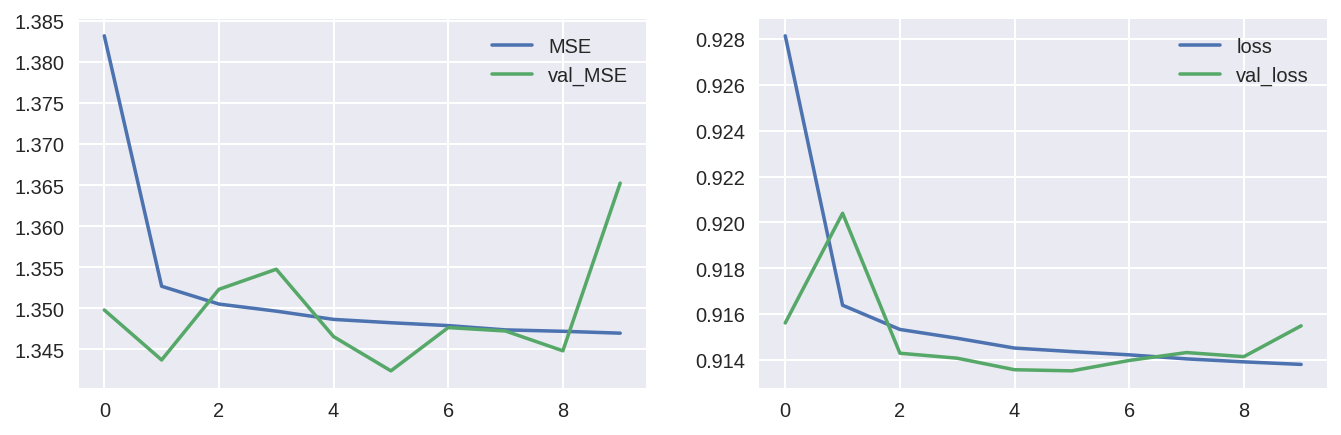

In [24]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.plot(history.history['val_mean_squared_error'], label='val_MSE')
plt.legend()

plt.show()

In [25]:
model.save('drive/MyDrive/Deep/DenseNN.hdf5')

In [26]:
description="Red neuronal densa para la predicción de marcadores de fosforilación"
show_results(description, model, X_train, y_train, X_val, y_val, X_test, y_test)

Score done
cross val score done
Score 2 done
Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.510		R² = 0.510		R² = 0.510
MAE = 0.91					MAE = 0.91


In [27]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Red neuronal densa para la predicción de marcadores de fosforilación,0.510336,0.509645,0.509724,0.914895,0.914999


En el caso de querer este modelo habría que entrenarlo nuevamente utilizando solo 8 epoch, ya que después de ese momento el rendimiento ha sido peor y ha habido sobreajuste. El sobreajuste se intentó remediar haciendo uso de redes neuronales menos complejas, utilizando 256, 256 y 256 neuronas o 256, 512 y 512 neuronas. Estos modelos presentaron un desempeño peor que el mostrado anteriormente. El primero de ellos, no tenía la complejidad suficiente como para aprender propiamente de los datos y aunque este aprendiera en los sucesivos epoch, se estancaba muy rápido y ya no mejoraba los valores de pérdida y MAE. El segundo modelo tenía mayor capacidad para aprender de los datos, pero el sobreajuste mostrado era muy similar al obtenido por el modelo presentado y además los valores obtenidos de R^2, pérdida y MAE eran notablemente peores.


Ahora vamos a comenzar con un modelo un tanto más complejo, para eso utilizaremos redes neuronales convolucionales pero de 1 dimensión, similares a las que se utilizan para encontrar patrones en los problemas de análisis de imagen, pero esta vez sólamente en una dimensión ya que tenemos la suerte de tener datos estructurados.

In [55]:
#Para poder usar las redes neuronales convolucionales 1D tenemos que cambiar la forma de nuestros datos.
sample_size = X_train.shape[0] # nº de muestras de entrenamiento
test_size = X_test.shape[0]
val_size = X_val.shape[0]
time_steps  = X_train.shape[1] # número de variables
input_dimension = 1 

train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
test_data_reshaped = X_test.reshape(test_size,time_steps,input_dimension)
val_data_reshaped = X_val.reshape(val_size,time_steps,input_dimension)

print("La forma del dataset ahora es:\n", train_data_reshaped.shape)
print("La forma de cada muestra es:\n",train_data_reshaped[0].shape)
print("Un ejemplo:\n", train_data_reshaped[0])

La forma del dataset ahora es:
 (1069754, 39, 1)
La forma de cada muestra es:
 (39, 1)
Un ejemplo:
 [[-8.77194415e-01]
 [ 1.21311511e+00]
 [-9.72804361e-01]
 [ 1.80935965e-01]
 [-8.53267373e-01]
 [ 3.99671727e-01]
 [ 7.41909215e-01]
 [ 3.44897936e-01]
 [ 5.07249056e-04]
 [-1.99606895e-03]
 [-1.01234497e+00]
 [ 6.87596919e-02]
 [-3.86604683e-03]
 [ 4.16290915e-01]
 [-1.17318549e-01]
 [ 1.37051122e+00]
 [ 7.71523811e-01]
 [-1.67227305e-01]
 [-6.96508778e-02]
 [-2.59971443e-01]
 [ 1.70134597e+00]
 [ 5.25926187e-01]
 [-1.09080781e+00]
 [-2.16512419e-01]
 [ 7.04736018e-01]
 [-5.26185574e-01]
 [ 3.67864867e-01]
 [-9.18688880e-01]
 [-5.35254794e-01]
 [ 3.26192891e-01]
 [ 1.85185962e+00]
 [ 5.10332834e-01]
 [ 1.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.00000000e+00]]


In [ ]:
#Construimos la red con tres capas convolucionales y una red densa fully conected con 1024 neuronas
n_timesteps = train_data_reshaped.shape[1]
n_features  = train_data_reshaped.shape[2]

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(n_timesteps,n_features)),
  tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu'),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(5)
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 33, 32)            256       
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 29, 32)            5152      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 27, 32)            3104      
_________________________________________________________________
flatten_3 (Flatten)          (None, 864)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              885760    
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 5125      
Total params: 899,397
Trainable params: 899,397
Non-trainable params: 0
________________________________________________

In [ ]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=['MeanSquaredError'])

In [ ]:
# Entrenamos
history = model.fit(train_data_reshaped, y_train, epochs=10, validation_data=(val_data_reshaped, y_val))

Epoch 1/10
33430/33430 [==============================] - 658s 20ms/step - loss: 0.8600 - mean_squared_error: 1.2449 - val_loss: 0.7973 - val_mean_squared_error: 1.0949
Epoch 2/10
33430/33430 [==============================] - 659s 20ms/step - loss: 0.7929 - mean_squared_error: 1.0845 - val_loss: 0.7884 - val_mean_squared_error: 1.0918
Epoch 3/10
33430/33430 [==============================] - 662s 20ms/step - loss: 0.7837 - mean_squared_error: 1.0659 - val_loss: 0.7828 - val_mean_squared_error: 1.0755
Epoch 4/10
33430/33430 [==============================] - 659s 20ms/step - loss: 0.7784 - mean_squared_error: 1.0550 - val_loss: 0.7829 - val_mean_squared_error: 1.0498
Epoch 5/10
33430/33430 [==============================] - 661s 20ms/step - loss: 0.7754 - mean_squared_error: 1.0502 - val_loss: 0.7800 - val_mean_squared_error: 1.0510
Epoch 6/10
33430/33430 [==============================] - 654s 20ms/step - loss: 0.7728 - mean_squared_error: 1.0446 - val_loss: 0.7779 - val_mean_squared_

In [ ]:
# Evaluamos con el conjunto de test
model.evaluate(x=test_data_reshaped, y=y_test)

24576/24576 [==============================] - 106s 4ms/step - loss: 0.7786 - mean_squared_error: 1.0564


[0.7786304950714111, 1.0564287900924683]

In [ ]:
#Guardar el modelo y los resultados
model.save('drive/MyDrive/Deep/Conv1DNN.hdf5')

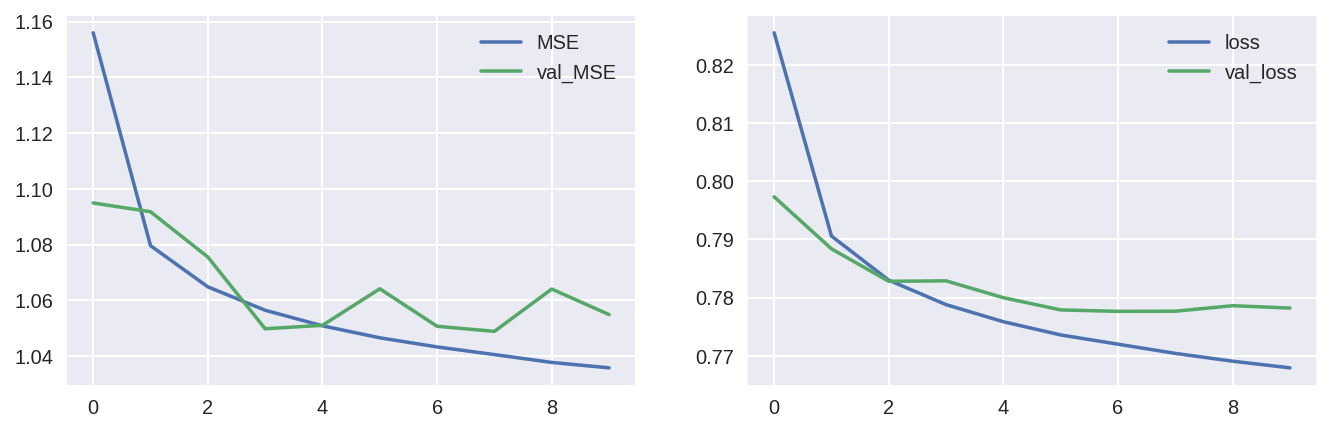

In [ ]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.plot(history.history['val_mean_squared_error'], label='val_MSE')
plt.legend()

plt.show()

Observamos que en las últimas epoch parece haber algo de sobreajuste y se comienzan a separar los valores de entrenamiento y test 

In [ ]:
#Guardar el modelo y los resultados
model.save('content/drive/MyDrive/Deep/Conv1DNN.hdf5')

In [ ]:
description="Red neuronal Conv1D para la predicción de marcadores de fosforilación"
show_results(description, model, train_data_reshaped, y_train, val_data_reshaped, y_val, test_data_reshaped, y_test)

Score done
cross val score done
Score 2 done
Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.631		R² = 0.621		R² = 0.620
MAE = 0.77					MAE = 0.78


In [ ]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Red neuronal Conv1D para la predicción de marcadores de fosforilación,0.631312,0.621124,0.62033,0.765393,0.778632


Vemos que **parece haber cierto sobreajuste** al hacer análsis de la progresión de los epoch. Pero los valores de R^2 y MAE muestran que el problema de sobreajuste no es desmedido, además vemos que el desempeño de este modelo sí que parece ser más robusto, teniendo valores de R^2 superiores a 0,6 tanto para validación cómo test, el MAE parece ser también el mejor hasta la fecha y parece que el desempeño del modelo es por lo general bueno. 

Alternativamente se han probado otras variantes de este modelo, reduciendo la complejidad de la red neuronal densa (256 neuronas y 512 neuronas respectivamente) y también se ha probado a ajustar el learning rate (0,01 y 0,0001) pero el mejor desempeño se obtuvo con el modelo presentado en este trabajo. La reducción de la complejidad el modelo era incapaz de aprender, cuando el learning rate se reducía, el modelo avanzaba demasiado lento en el aprendizaje y cuando el learning rate aumentaba conseguíamos un sobreajuste acrecentado ya desde las primeras epoch.

Por último, para intentar mejorar el desempeño del modelo vamos a realizar un último modelo intercalando con capas de MaxPooling 1D y dropout para conseguir reducir el sobreajuste y ver si conseguimos sacar mejores patrones sobre las muestras.

In [30]:
#Generamos la red
n_timesteps = train_data_reshaped.shape[1]
n_features  = train_data_reshaped.shape[2]

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(n_timesteps,n_features)),
  tf.keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu'),
  tf.keras.layers.MaxPool1D(pool_size=2,strides=None),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.MaxPool1D(pool_size=2,strides=None),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPool1D(pool_size=2,strides=None),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 32)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 32)             3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 32)           

In [31]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=['MeanSquaredError'])

In [32]:
# Entrenamos
history = model.fit(train_data_reshaped, y_train, epochs=10, validation_data=(val_data_reshaped, y_val))

Epoch 1/10
33430/33430 [==============================] - 304s 9ms/step - loss: 0.9148 - mean_squared_error: 1.3550 - val_loss: 0.8906 - val_mean_squared_error: 1.3214
Epoch 2/10
33430/33430 [==============================] - 247s 7ms/step - loss: 0.8963 - mean_squared_error: 1.3145 - val_loss: 0.8896 - val_mean_squared_error: 1.2661
Epoch 3/10
33430/33430 [==============================] - 236s 7ms/step - loss: 0.8904 - mean_squared_error: 1.3017 - val_loss: 0.8788 - val_mean_squared_error: 1.2635
Epoch 4/10
33430/33430 [==============================] - 262s 8ms/step - loss: 0.8840 - mean_squared_error: 1.2884 - val_loss: 0.8835 - val_mean_squared_error: 1.2725
Epoch 5/10
33430/33430 [==============================] - 275s 8ms/step - loss: 0.8796 - mean_squared_error: 1.2792 - val_loss: 0.8766 - val_mean_squared_error: 1.2612
Epoch 6/10
33430/33430 [==============================] - 259s 8ms/step - loss: 0.8772 - mean_squared_error: 1.2727 - val_loss: 0.8809 - val_mean_squared_error:

In [33]:
# Evaluamos con el conjunto de test
model.evaluate(x=test_data_reshaped, y=y_test)

24576/24576 [==============================] - 55s 2ms/step - loss: 0.8804 - mean_squared_error: 1.2619


[0.8803659081459045, 1.2619251012802124]

In [34]:
#Guardar el modelo y los resultados
model.save('drive/MyDrive/Deep/Conv1DNN_2.hdf5')

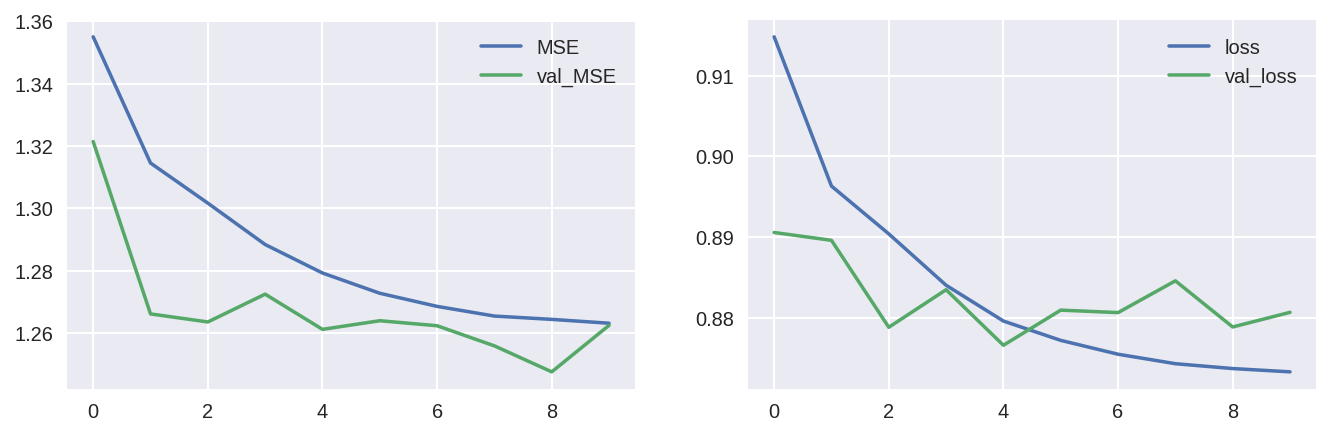

In [35]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.plot(history.history['val_mean_squared_error'], label='val_MSE')
plt.legend()

plt.show()

Vemos que ahora no parece haber  cierto sobreajuste,  además de que los resultados no son notablemente mejores que los del modelo anterior. En este modelo se ha probado a añadir más capas de DropOut para intentar reducir el sobreentrenamiento y entrenar durante más epoch (50) para ver si conseguimos un mejor desempeño. El incremento de las capas de DropOut en exceso hacía que a partir del segundo epoch los valores de pérdida y MSE no mejoraran ni para el conjunto de entrenamiento ni validación. Al entrenar este modelo durante más epoch, cada vez se acrecentaba más el sobreajuste de los datos y comenzaba a desviarse en mayor medida los estadísticos obtenidos en entrenamiento, validación y test.

In [36]:
description="Red neuronal Conv1D con DropOut y Maxpool para la predicción de marcadores de fosforilación"
show_results(description, model, train_data_reshaped, y_train, val_data_reshaped, y_val, test_data_reshaped, y_test)

Score done
cross val score done
Score 2 done
Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.548		R² = 0.547		R² = 0.546
MAE = 0.88					MAE = 0.88


In [38]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Red neuronal Conv1D con DropOut y Maxpool para la predicción de marcadores de fosforilación,0.547878,0.546573,0.546477,0.879364,0.88037


**Resultados finales**

In [102]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Ridge regression para la predicción de marcadores de fosforilación,0.107172,0.107121,0.106924,0.911959,0.911695
Regression tree para la predicción de marcadores de fosforilación,0.262342,0.199459,0.204143,0.800711,0.833326
Random forest para la predicción de marcadores de fosforilación,0.484126,0.267036,0.269355,0.659202,0.796952
k-NN (STD) para la predicción de marcadores de fosforilación,0.280478,0.203063,0.203025,0.791528,0.832757
Red neuronal densa para la predicción de marcadores de fosforilación,0.510336,0.509645,0.509724,0.914895,0.914999
Red neuronal Conv1D para la predicción de marcadores de fosforilación,0.631312,0.621124,0.620330,0.765393,0.778632
Red neuronal Conv1D con DropOut y Maxpool para la predicción de marcadores de fosforilación,0.547878,0.546573,0.546477,0.879364,0.880370


Finalmente, para comprobar si el desempeño de alguno de los modelos es mejor para la predicción de algunas de las variables y no del resto, vamos a analizar el desempeño de los modelos de machine learning para las distintas variables por separado.

In [4]:
#Función para calcular los errores

if not os.path.isfile("Results_fosfo.csv"):
    results_fosfo=pd.DataFrame(columns=['Modelo','$R^2$e ERK', '$R^2$e Akt.Ser473', '$R^2$e S6', 
                                        '$R^2$e HER2', '$R^2$e PLCg2', '$R^2$t ERK', '$R^2$t Akt.Ser473', 
                                      '$R^2$t S6', '$R^2$t HER2', '$R^2$t PLCg2']).set_index('Modelo')
# Si se habían generado anteriormente, y el archivo está disponible, lo lee. 
else:
    results_fosfo=pd.read_csv("Results_fosfo.csv", index_col=0)


def show_results_fosfo(description, model, X_train, y_train, X_test, y_test):
  prots={"p.ERK":0, "p.Akt.Ser473.":1, "p.S6":2, "p.HER2":3, "p.PLCg2":4}
  pred_train=pd.DataFrame(model.predict(X_train))
  pred_test=pd.DataFrame(model.predict(X_test))
  train_r2=[]
  test_r2=[]
  for prot, pos in prots.items():
    train_r2.append(R_squared(y_train[prot], pred_train[pos]).numpy())
    test_r2.append(R_squared(y_test[prot], pred_test[pos]).numpy())
    print(prot)
  values=train_r2+test_r2
  results_fosfo.loc[description]=values
  

In [ ]:
model=tf.keras.models.load_model("drive/MyDrive/Deep/DenseNN_256_2.hdf5")
description="Red neuronal densa para la predicción de marcadores de fosforilación"
show_results_fosfo(description, model, X_train, y_train, X_test, y_test)
model=tf.keras.models.load_model("drive/MyDrive/Deep/Conv1DNN.hdf5")
description="Red neuronal Conv1D para la predicción de marcadores de fosforilación"
show_results_fosfo(description, model, X_train, y_train, X_test, y_test)
model=tf.keras.models.load_model("drive/MyDrive/Deep/Conv1DNN_2.hdf5")
description="Red neuronal Conv1D con DropOut y Maxpool para la predicción de marcadores de fosforilación"
show_results_fosfo(description, model, X_train, y_train, X_test, y_test)

In [69]:
results_fosfo

,$R^2$e ERK,$R^2$e Akt.Ser473,$R^2$e S6,$R^2$e HER2,$R^2$e PLCg2,$R^2$t ERK,$R^2$t Akt.Ser473,$R^2$t S6,$R^2$t HER2,$R^2$t PLCg2
Modelo,,,,,,,,,,
Red neuronal densa para la predicción de marcadores de fosforilación,0.147212,0.114115,0.052677,0.066916,0.003556,0.145847,0.113330,0.052306,0.065841,0.002811
Red neuronal Conv1D para la predicción de marcadores de fosforilación,0.482292,0.336129,0.254800,0.231470,0.120746,0.464738,0.313079,0.230055,0.214886,0.107358
Red neuronal Conv1D con DropOut y Maxpool para la predicción de marcadores de fosforilación,0.221935,0.180632,0.107237,0.104972,0.057767,0.219291,0.177386,0.104608,0.102801,0.057092


In [5]:
#Añadiremos los datos de los resultados individuales al dataframe
individual=results.tail(5)
individual = individual.stack()
individual.index = individual.index.map('{0[1]}_{0[0]}'.format)
individual=individual.to_frame().T
individual=individual.iloc[:,[0,5,10,15,20, 2,7,12,17,22]]
results_fosfo.loc["Random forest para la predicción individual de marcadores de fosforilación"]=individual.values.tolist()[0]

In [15]:
results_fosfo.to_csv("result_fosfo.csv")

In [17]:
result_fosfo=pd.read_csv("result_fosfo.csv", index_col=0)

In [7]:
result_fosfo_comp=results_fosfo.iloc[0]
pd.DataFrame(result_fosfo_comp).T

,$R^2$e ERK,$R^2$e Akt.Ser473,$R^2$e S6,$R^2$e HER2,$R^2$e PLCg2,$R^2$t ERK,$R^2$t Akt.Ser473,$R^2$t S6,$R^2$t HER2,$R^2$t PLCg2
Red neuronal densa para la predicción de marcadores de fosforilación,0.147212,0.114115,0.052677,0.066916,0.003556,0.145847,0.11333,0.052306,0.065841,0.002811


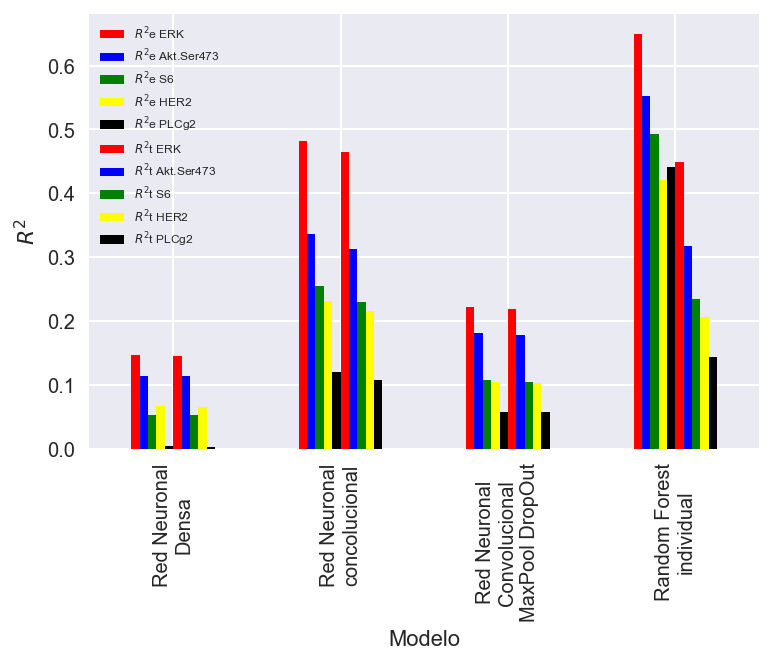

In [10]:
results_fosfo.plot.bar(color=["red","blue","green","yellow","black","red","blue","green","yellow","black"])
plt.xticks([0, 1, 2, 3],
           ["Red Neuronal\nDensa", "Red Neuronal\nconcolucional", 
            "Red Neuronal\nConvolucional\nMaxPool DropOut", "Random Forest\nindividual"])
plt.legend(prop={'size': 6})
plt.ylabel("$R^2$")
plt.savefig('fosfo.png', dpi=600, bbox_inches='tight', transparent=True)

Podemos observar que el modelo 2, el compuesto por capas convolucionales unidimensionales y con una capa de neuronas densa fully-conected, presenta un mejor desempeño que los demás modelos de DL, tanto en training como en test para todos los marcadores de fosforilación. Vemos que todos los modelos funcionan notablemente mejor a la hora de predecir los valores de p.ERK y en la que peor desempeño presentan es en la predicción de p.PLCg2. Podemos observar también que los valores de entrenamiento y test son relativamente similares, por lo tanto, pese a que existe cierto sobreajuste en los datos, este no es demasiado severo y permite una buena predicción de los valores. En cambio, vemos que el desempeño de los modelos de RF individuales para cada uno de los marcadores ha tenido un mejor desempeño en especial para el caso de entrenamiento (lo cual es normal ya que los modelos de RF tienden a sobreajustar y si establecieramos suficiente profundidad deberíamos llegar a explicar el 100% de la variabilidad, mientras que en test los valores son muy similares a los obtenidos por la red neuronal convolucional aunque en algunos casos es ciertamente mejor, por ello, la combinación de los 5 modelos individuales de RF parece ser la que mejores resultados ha obtenido.

Por último probamos a analizar si el modelo de DL también tendrían un mejor desempeño siendo entrenado individualmente para la predicción de solo una de estas variables, procedimos a hacer una prueba con la arquitectura que mejor funcionó entrenando en este caso para la predicción de solo uno de estos valores.

In [ ]:
n_timesteps = train_data_reshaped.shape[1]
n_features  = train_data_reshaped.shape[2]

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(n_timesteps,n_features)),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 32)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 32)            5152      
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 32)            5152      
                                                                 
 flatten (Flatten)           (None, 864)               0         
                                                                 
 dense (Dense)               (None, 1024)              885760    
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 897,281
Trainable params: 897,281
Non-trai

In [ ]:
# Configuramos entrenamiento
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='mean_absolute_error',
              metrics=['MeanSquaredError'])

In [ ]:
# Entrenamos
history = model.fit(train_data_reshaped, y_train["p.ERK"], epochs=10, validation_data=(val_data_reshaped, y_val["p.ERK"]))

Epoch 1/10
33430/33430 [==============================] - 881s 26ms/step - loss: 0.7224 - mean_squared_error: 0.8868 - val_loss: 0.6796 - val_mean_squared_error: 0.7947
Epoch 2/10
33430/33430 [==============================] - 800s 24ms/step - loss: 0.6764 - mean_squared_error: 0.7918 - val_loss: 0.6693 - val_mean_squared_error: 0.7732
Epoch 3/10
33430/33430 [==============================] - 803s 24ms/step - loss: 0.6657 - mean_squared_error: 0.7715 - val_loss: 0.6641 - val_mean_squared_error: 0.7793
Epoch 4/10
33430/33430 [==============================] - 792s 24ms/step - loss: 0.6601 - mean_squared_error: 0.7620 - val_loss: 0.6612 - val_mean_squared_error: 0.7600
Epoch 5/10
33430/33430 [==============================] - 791s 24ms/step - loss: 0.6563 - mean_squared_error: 0.7546 - val_loss: 0.6576 - val_mean_squared_error: 0.7576
Epoch 6/10
33430/33430 [==============================] - 801s 24ms/step - loss: 0.6534 - mean_squared_error: 0.7494 - val_loss: 0.6592 - val_mean_squared_

In [ ]:
# Evaluamos con el conjunto de test
model.evaluate(x=test_data_reshaped, y=y_test["p.ERK"])

24576/24576 [==============================] - 135s 6ms/step - loss: 0.6568 - mean_squared_error: 0.7547


[0.6567888259887695, 0.7547233700752258]

In [ ]:
#Guardar el modelo y los resultados
model.save('drive/MyDrive/Deep/Conv1DNN_1024_ERK.hdf5')

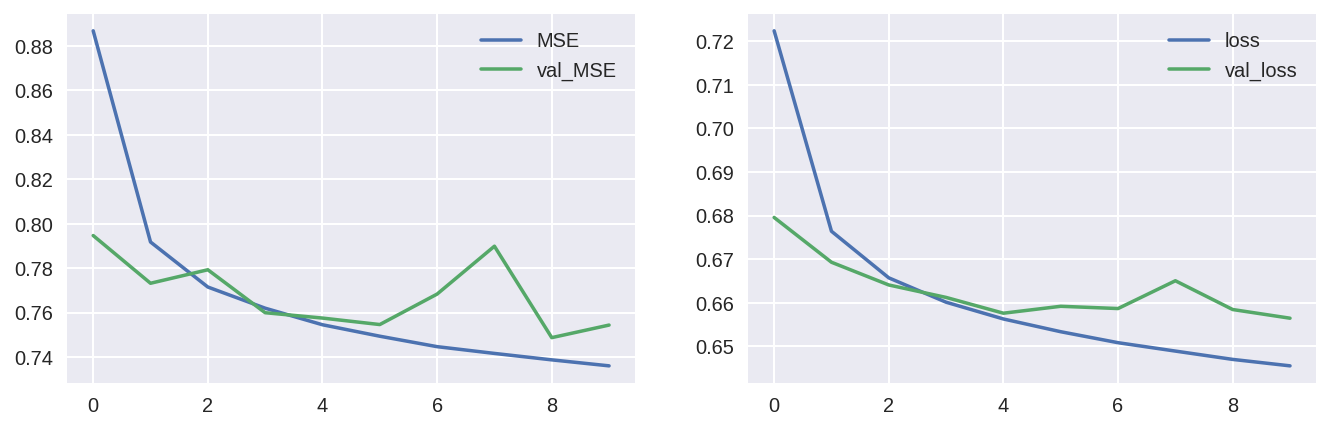

In [ ]:
# Visualizamos la evolución de los epochs
fig=plt.figure(figsize=(60, 40))

# error
fig.add_subplot(10, 10, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# precision
fig.add_subplot(10, 10, 1)
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.plot(history.history['val_mean_squared_error'], label='val_MSE')
plt.legend()

plt.show()

In [18]:
description="Red neuronal Conv1D para la predicción de fosfo ERK"
show_results(description, model, X_train, y_train, X_val, y_val, X_test, y_test)

Score done
cross val score done
Score 2 done
Training 		xValidation 		Test
-------- 		----------- 		----
R² = 0.485		R² = 0.466		R² = 0.465
MAE = 0.64					MAE = 0.66


In [19]:
results

,$R^2$ Entrenamiento,$R^2$ Validación,$R^2$ Test,MAE Entrenamiento,MAE Test
Modelo,,,,,
Red neuronal Conv1D para la predicción de fosfo ERK,0.484806,0.466013,0.464741,0.641198,0.656787


Podemos observar que el desempeño del modelo entrenado para la predicción de sólamente el marcador p.ERK es casi idéntico al desempeño del modelo completo y que por lo tanto, parece que no merece la pena generar modelos individuales para cada una de las variables.